<a href="https://colab.research.google.com/github/ayushpratapno1/image-classification/blob/main/classification_real_vs_ai_generated_images.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Loading Required Libraries

In [1]:
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from matplotlib import pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras import layers, models
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import numpy as np
import cv2
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import Precision, Recall, BinaryAccuracy
import kagglehub

In [2]:
# GPU configuration
try:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        print(f"Found {len(gpus)} GPU(s)")
    else:
        print("No GPU found, using CPU")
except Exception as e:
    print(f"GPU configuration error: {e}")

Found 1 GPU(s)


# Load image dataset

In [20]:
# Download latest version
path = kagglehub.dataset_download("birdy654/cifake-real-and-ai-generated-synthetic-images")
print("Path to dataset files:", path)

# Create train/validation split properly using validation_split parameter
train_data = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(224, 224),
    batch_size=64
)

val_data = tf.keras.utils.image_dataset_from_directory(
    path,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(224, 224),
    batch_size=64
)

# CRITICAL: Add repeat() to prevent data exhaustion
train_data = train_data.repeat()
val_data = val_data.repeat()

print(f"Training batches: {tf.data.experimental.cardinality(train_data.take(1000))}")
print(f"Validation batches: {tf.data.experimental.cardinality(val_data.take(500))}")

Path to dataset files: /kaggle/input/cifake-real-and-ai-generated-synthetic-images
Found 120000 files belonging to 2 classes.
Using 96000 files for training.
Found 120000 files belonging to 2 classes.
Using 24000 files for validation.
Training batches: 1000
Validation batches: 500


# Visualizing  of sample set of images


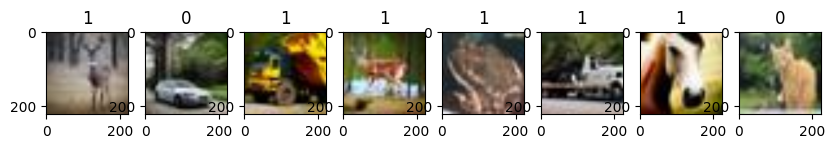

In [21]:
data_it = train_data.as_numpy_iterator()
batch = data_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

# Normalizing the dataset for faster computation
To Normalize the data set I am # scaling pixel values to the range [0, 1]


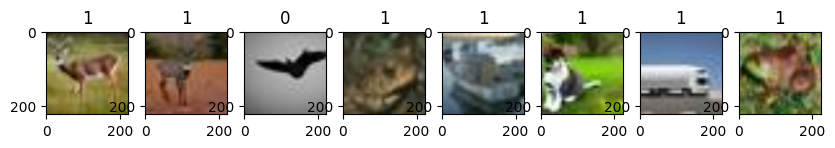

In [22]:
# Normalizing the dataset for faster computation
# scaling pixel values to the range [0, 1]
train_data = train_data.map(lambda x, y : (x/255, y))
val_data = val_data.map(lambda x, y : (x/255, y))

# Showing scaled sample of images (use train_data instead of data)
scaled_it = train_data.as_numpy_iterator()
batch = scaled_it.next()

fig, ax = plt.subplots(ncols=8, figsize=(10, 10))
for idx, img in enumerate(batch[0][:8]):
    ax[idx].imshow(img.astype(float))
    ax[idx].title.set_text(batch[1][idx])

# Splitting Data to Train, Test, Validation

# Model Building
I have used pretrained ResNet50 as base model without freezing it's layers

In [23]:
from tensorflow.keras.models import Model

# Load pre-trained ResNet50 model base
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Define the model using the Functional API
input_tensor = tf.keras.Input(shape=(224, 224, 3))
x = base_model(input_tensor)
x = layers.Flatten()(x)
x = layers.Dense(256, activation='relu')(x)
x = layers.BatchNormalization()(x)
x = layers.Dropout(0.5)(x)
x = layers.Dense(128, activation='relu')(x)
output_tensor = layers.Dense(1, activation='sigmoid')(x) # Adjust the final layer according to your task

model = Model(inputs=input_tensor, outputs=output_tensor)

# Overview of the Model
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ resnet50 (Functional)           │ (None, 7, 7, 2048)     │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 49,312,129 (188.11 MB)

 Trainable params: 49,258,497 (187.91 MB)

 Non-trainable params: 53,632 (209.50 KB)

In [24]:
# Learning rate scheduler
initial_learning_rate = 0.001
def lr_scheduler(epoch, lr):
    return lr * 0.95
lr_schedule = LearningRateScheduler(lr_scheduler)
optimizer = Adam(learning_rate=initial_learning_rate)

# Compiling the model
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Data Augumentation

In [25]:
# Data Augmentation in the pipeline
def augment_data(x, y):
    x = tf.image.random_flip_left_right(x)
    x = tf.image.random_flip_up_down(x)
    x = tf.image.random_brightness(x, max_delta=0.1)
    x = tf.image.random_contrast(x, lower=0.9, upper=1.1)
    return x, y

# Apply augmentation to training data
train_augmented = train_data.map(augment_data)
train_augmented = train_augmented.prefetch(tf.data.AUTOTUNE)
val_data = val_data.prefetch(tf.data.AUTOTUNE)




# Model Training

In [26]:
# Calculate steps to prevent infinite training
steps_per_epoch = 3000  # Adjust based on your dataset size
validation_steps = 750   # Adjust based on your dataset size

# Early Stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Train the model with explicit steps
history = model.fit(
    train_augmented,
    validation_data=val_data,
    epochs=1,
    steps_per_epoch=steps_per_epoch,      # ADD THIS
    validation_steps=validation_steps,    # ADD THIS
    callbacks=[lr_schedule, early_stopping]
)

3000/3000 ━━━━━━━━━━━━━━━━━━━━ 1750s 560ms/step - accuracy: 0.8238 - loss: 0.4857 - val_accuracy: 0.8314 - val_loss: 0.4563 - learning_rate: 9.5000e-04


In [27]:
# Create a separate test dataset
test_data = val_data.take(200)  # Take 200 batches for testing

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_data, steps=200)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')

200/200 ━━━━━━━━━━━━━━━━━━━━ 28s 141ms/step - accuracy: 0.8327 - loss: 0.4547
Test Accuracy: 83.13%






# Plotting Model Accuracy & Loss

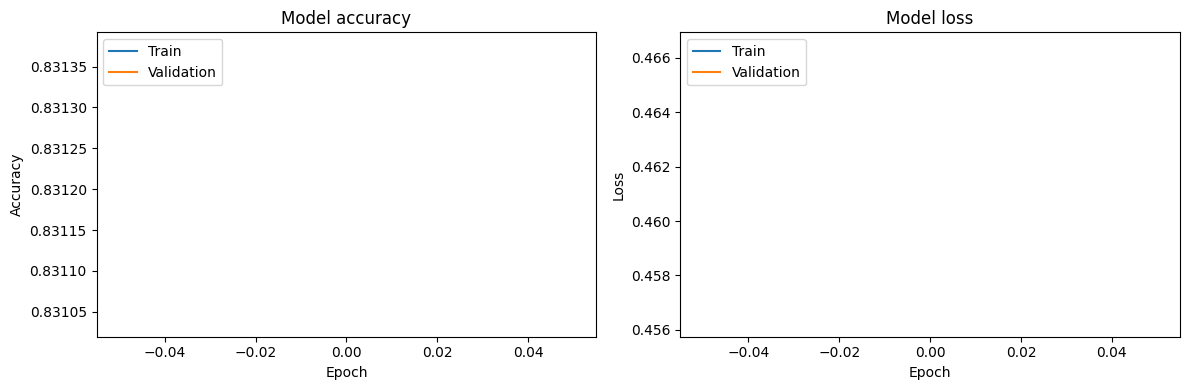

Test Accuracy: 83.13%
Test Loss: 0.4568


In [29]:
# Plotting Model Accuracy & Loss
plt.figure(figsize=(12, 4))

# Plot training & validation accuracy values
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
if 'val_accuracy' in history.history:
    plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')

# Precision, Recall & Accuracy

In [30]:
# Precision, Recall & Accuracy
pre = Precision()
rec = Recall()
acc = BinaryAccuracy()

# Use the test_data you created earlier (val_data.take(200))
test_evaluation_data = val_data.take(200)  # Match your earlier test creation

for batch in test_evaluation_data.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    acc.update_state(y, yhat)

print(f'Precision: {pre.result().numpy():.4f}')
print(f'Recall: {rec.result().numpy():.4f}')
print(f'Accuracy: {acc.result().numpy():.4f}')


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 96ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 114ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
2/2 ━━

**Save & Loaded The Model**

In [18]:
import os

# Create the 'model' directory if it doesn't exist
os.makedirs('model', exist_ok=True)

# Assuming 'model' is your Keras model
model.save('model/ai_imageclassifier.keras')

loaded_model = tf.keras.models.load_model('model/ai_imageclassifier.keras')

In [ ]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login() # This will ask for an access token from your HF account.

In [ ]:
from huggingface_hub import HfApi

api = HfApi(token=os.getenv("HF_TOKEN"))
api.upload_folder(
    folder_path="/content/model/",
    repo_id="ayush-pratap05/ai_imageclassifier.keras",
    repo_type="model",
)

# Model Prediction On Any Single Image

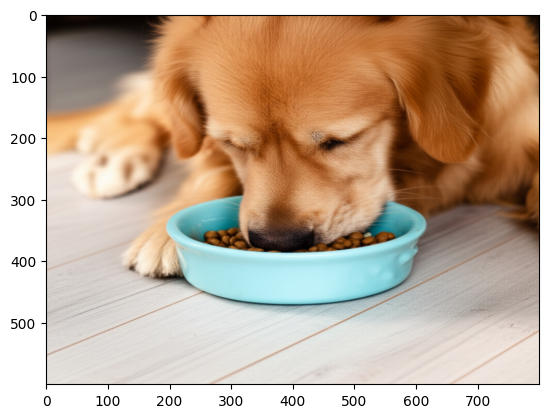

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
Prediction probability: 0.7051
Predicted class: REAL (confidence: 0.705)


In [39]:
# Model Prediction On Any Single Image

# Load the image
image_path = '/content/a golden retriv.png'

try:
    img = cv2.imread(image_path)
    if img is None:
        raise FileNotFoundError(f"Could not read the image from {image_path}")
    img = cv2.resize(img, (800, 600))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.imshow(img)
    plt.show()

except Exception as e:
    print(f"Error: {e}")

# IMPORTANT: Match your training image size
# If you used 224x224 in training:
resize = tf.image.resize(img, (224, 224))
# If you used 32x32 in training:
# resize = tf.image.resize(img, (32, 32))

y_pred = model.predict(np.expand_dims(resize/255, 0))
print(f"Prediction probability: {y_pred[0][0]:.4f}")

if y_pred > 0.5:
    print(f'Predicted class: REAL (confidence: {y_pred[0][0]:.3f})')
else:
    print(f'Predicted class: AI (confidence: {1-y_pred[0][0]:.3f})')


# Classification Report & Confusion Matrix

Evaluating model on test data...


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


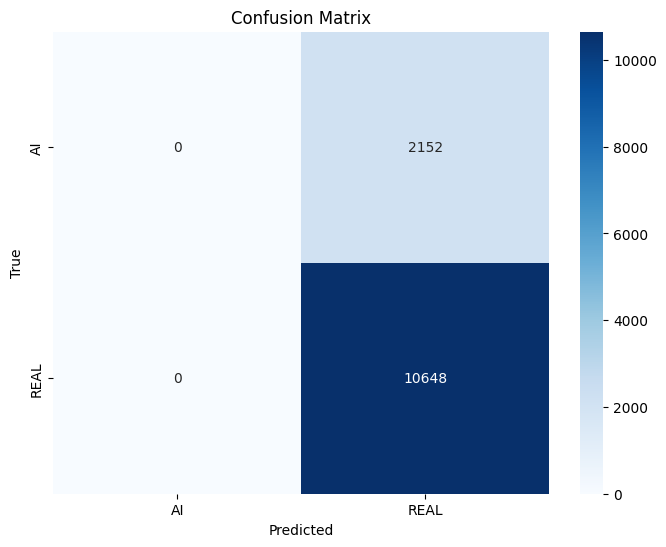

Classification Report:
               precision    recall  f1-score   support

          AI       0.00      0.00      0.00      2152
        REAL       0.83      1.00      0.91     10648

    accuracy                           0.83     12800
   macro avg       0.42      0.50      0.45     12800
weighted avg       0.69      0.83      0.76     12800

Total samples evaluated: 12800
Accuracy: 0.8319


In [35]:
# Classification Report & Confusion Matrix

# Use consistent test dataset
test_evaluation_data = val_data.take(200)  # Match your test set size

y_true = []
y_pred_probs = []

print("Evaluating model on test data...")
batch_count = 0
for batch in test_evaluation_data.as_numpy_iterator():
    X, y = batch
    y_true.extend(y)
    predictions = model.predict(X, verbose=0)  # Suppress prediction output
    y_pred_probs.extend(predictions.flatten())
    batch_count += 1
    if batch_count >= 200:  # Limit to prevent infinite loop
        break

# Convert probabilities to binary predictions
y_pred = np.array(y_pred_probs) > 0.5

# Confusion Matrix
conf_mat = confusion_matrix(y_true, y_pred)

# Classification Report
class_report = classification_report(y_true, y_pred, target_names=['AI', 'REAL'])

# Plot Confusion Matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
           xticklabels=['AI', 'REAL'], yticklabels=['AI', 'REAL'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Display Classification Report
print("Classification Report:\n", class_report)

print(f"Total samples evaluated: {len(y_true)}")
print(f"Accuracy: {np.mean(y_true == y_pred):.4f}")
